# Card Transaction Analysis

As we have already discussed, source of this data is same NCPI website "https://rbi.org.in" which we used in NEFT Analysis. Here I am skipping libraries and process description as we have already seen it. 

In case you need decription of few libs like Seaborn and Scikit learn used here, internet will help :). These are enormous libraries where first one is for Visualizations and second one is for Machine Learning and data processing. 

In [1]:
from urllib2 import urlopen,Request
from bs4 import BeautifulSoup
from pandas import DataFrame,Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from datetime import datetime
import os

In [2]:
df = pd.read_excel('ATMCS020320174998E7DF762F4563B616BFDD89CBE768.XLSX',header=[1,2,3,4],skip_footer=15)
df.head(2)

ATM & Card Statistics for December 2016                     \
                                    Sr. No.          Bank Name   
                         Unnamed: 0_level_2 Unnamed: 1_level_2   
                         Unnamed: 0_level_3 Unnamed: 1_level_3   
NaN                                     NaN                NaN   
NaN                                     1.0     ALLAHABAD BANK   

                                                              \
                  ATMs                                   POS   
               On-site           Off-site            On-line   
    Unnamed: 2_level_3 Unnamed: 3_level_3 Unnamed: 4_level_3   
NaN                1.0                2.0                3.0   
NaN              817.0              404.0                9.0   

                                                                            \
                                                              Credit Cards   
              Off-line No .of outstanding cards as at the end of the month   
    Unnamed: 5_level_3                                  Unnamed: 6_level_3   
NaN                4.0                                                5.0    
NaN                0.0                                                0.0    

                                         \
                                          
    No. of Transactions\n(Actuals)        
                               ATM  POS   
NaN                            6.0  7.0   
NaN                            0.0  0.0   

                                                 \
                                                  
    Amount of transactions\n(Rs. Millions)        
                                       ATM  POS   
NaN                                    8.0  9.0   
NaN                                    0.0  0.0   

                                                         \
                                            Debit Cards   
    No .of outstanding cards as at the end of the month   
                                                    POS   
NaN                                               10.0    
NaN                                         10571221.0    

                                               \
                                                
    No. of Transactions\n(Actuals)              
                               ATM        POS   
NaN                           11.0       12.0   
NaN                      5641216.0  2356664.0   

                                                         
                                                         
    Amount of transactions\n(Rs. Millions)               
                                       ATM          POS  
NaN                              13.000000    14.000000  
NaN                            7166.341486  3532.318434

Key Analysis to Make:
1. Increase in total number of POS transactions Daily Avg, Aggergated MoM and QoQ
2. Is there a decrease in ATM tnx because of demonitisation
3. Which Bank has maximum Card (Cr+Deb) to Number of POS tnx ratio
4. Which Banks have maximum credit card txn from ATM
5. Which bank has issues max credit card (lets use Credit card/Debit Card ratio) 
6. Which bank has max ATM avalable (ATM/Debit Card Ratio)
7. Is there a increase in number of POS machines
8. Which banks should increase number of POS machines 

# Data Prep

Let me now get the column Names and read all the xls files in one data frame. I should have used the existing functions to fetch these details but just wanted to avoid the effort I would have to put to validate if the functions are working fine for NEFT transactions after modification. 
Another point is the analysis I am doing here is more adhoc in nature means whatever I encounter, I try to fix it there rather identfiying a generic solution. Here I will parse all the excel files downloaded for ATM transactions and create a master DataFrame. We can create a Panel aswell with all the DataFrames but it would complicate the analysis a bit for me. So I will stick with a concatenated DF. See how we can use concat method on a list of DataFrames. 

In [3]:
def get_cols(in_df):
    new_cols = []
    for x in in_df.tolist():
        new_cols.append(' '.join(['' if c.startswith('Un') else ' '.join(c.split()) for c in x]).strip())
    return new_cols

In [4]:
df_list = list()
for x in os.listdir(os.getcwd()):
    if x.endswith(('XLS','XLSX')):
        try:
            df_temp = pd.read_excel(x,header=[1,2,3,4],skip_footer=15,index=range(90))
            date_str = df_temp.columns.levels[0][0][df_temp.columns.levels[0][0].index('for ')+4:]
            df_temp.columns = get_cols(df_temp.columns.droplevel(0))
            df_temp['Date'] = pd.Period(date_str) 
            df_list.append(df_temp)
        except:
            print 'Error in ',file

            
master_df = pd.concat(df_list).copy()
master_df.head(2)

,,ATMs Off-site,ATMs On-site,Bank Name,Credit Cards Amount of transactions (Rs. Millions) ATM,Credit Cards Amount of transactions (Rs. Millions) POS,Credit Cards No .of outstanding cards as at the end of the month,Credit Cards No. of Transactions (Actuals) ATM,Credit Cards No. of Transactions (Actuals) POS,Credit Cards No. of outstanding cards as at the end of the month,Date,Debit Cards Amount of transactions (Rs. Millions) ATM,Debit Cards Amount of transactions (Rs. Millions) POS,Debit Cards No .of outstanding cards as at the end of the month POS,Debit Cards No. of Transactions (Actuals) ATM,Debit Cards No. of Transactions (Actuals) POS,Debit Cards No. of outstanding cards as at the end of the month POS,POS Off-line,POS On-line,Sr. No.
NaN,NaN,2.0,1.0,NaN,8.0,9.0,5.0,6.0,7.0,NaN,2016-01,13.0000,14.000000,10.0,11.0,12.0,NaN,4.0,3.0,NaN
NaN,NaN,421.0,791.0,ALLAHABAD BANK,0.0,0.0,0.0,0.0,0.0,NaN,2016-01,14722.4877,535.010038,8241040.0,5429027.0,368009.0,NaN,0.0,10.0,1.0


See above and you will find the concat has now changed the order of columns (now sorted alphabetically). I tried to correct it within concat function but this seems to be a bug in v.18 and .19. I am running .18, so I have fix it manually unless I move to .20

In [5]:
pd.__version__

u'0.18.0'

In [6]:
master_df = master_df.reindex_axis(df_list[0].columns,1)

In [7]:
# This one column was having a POS at the end which wasn't relevent. may be some bug in the excel.
cols_list = master_df.columns.values
cols_list[11]= 'Debit Cards No .of outstanding cards as at the end of the month'
master_df.columns = cols_list

In [8]:
master_df.head(2)

,Sr. No.,Bank Name,ATMs On-site,ATMs Off-site,POS On-line,POS Off-line,Credit Cards No .of outstanding cards as at the end of the month,Credit Cards No. of Transactions (Actuals) ATM,Credit Cards No. of Transactions (Actuals) POS,Credit Cards Amount of transactions (Rs. Millions) ATM,Credit Cards Amount of transactions (Rs. Millions) POS,Debit Cards No .of outstanding cards as at the end of the month,Debit Cards No. of Transactions (Actuals) ATM,Debit Cards No. of Transactions (Actuals) POS,Debit Cards Amount of transactions (Rs. Millions) ATM,Debit Cards Amount of transactions (Rs. Millions) POS,Date
NaN,NaN,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0000,14.000000,2016-01
NaN,1.0,ALLAHABAD BANK,791.0,421.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,8241040.0,5429027.0,368009.0,14722.4877,535.010038,2016-01


In [9]:
# Lets remove the NULLS
print 'Null:',len(master_df[master_df['Bank Name'].isnull()])
print 'Non Null:',len(master_df[master_df['Bank Name'].notnull()])

Null: 22
Non Null: 849


In [10]:
master_df = master_df[master_df['Bank Name'].notnull()].copy()

In [11]:
master_df['Date'].groupby(master_df['Date']).count()

Date
2016-01    56
2016-02    57
2016-03    57
2016-04    56
2016-05    56
2016-06    56
2016-07    56
2016-08    56
2016-09    57
2016-10    57
2016-11    57
2016-12    57
2017-01    57
2017-02    57
2017-03    57
Freq: M, dtype: int64

So the count across months is not matching. Lets pick up a month with higher nuber and see the tail. If assume its because of variable footers in the xls, some frames have got "Total" rows 

In [12]:
master_df[master_df['Date'] == pd.Period('1-2017',freq='M')].tail(3)

,Sr. No.,Bank Name,ATMs On-site,ATMs Off-site,POS On-line,POS Off-line,Credit Cards No .of outstanding cards as at the end of the month,Credit Cards No. of Transactions (Actuals) ATM,Credit Cards No. of Transactions (Actuals) POS,Credit Cards Amount of transactions (Rs. Millions) ATM,Credit Cards Amount of transactions (Rs. Millions) POS,Debit Cards No .of outstanding cards as at the end of the month,Debit Cards No. of Transactions (Actuals) ATM,Debit Cards No. of Transactions (Actuals) POS,Debit Cards Amount of transactions (Rs. Millions) ATM,Debit Cards Amount of transactions (Rs. Millions) POS,Date
NaN,55.0,ROYAL BANK OF SCOTLAND N V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,2017-01
NaN,56.0,STANDARD CHARTERED BANK LTD,103.0,147.0,0.0,0.0,1070421.0,4578.0,4584212.0,18.600000,9981.800000,862136.0,1034458.0,2409389.0,3.151800e+03,2962.000000,2017-01
NaN,NaN,Grand Total,108403.0,98206.0,2013601.0,2246.0,28845858.0,440618.0,112802575.0,1539.248767,327082.479038,817979145.0,712347249.0,328623459.0,1.516437e+06,490041.898963,2017-01


In [13]:
# Remove  Grand Totals which are creeped in due to variable footers
master_df = master_df[master_df['Sr. No.'].notnull()].copy()

In [14]:
# check of the count accross months is Same
master_df['Date'].groupby(master_df['Date']).count()

Date
2016-01    56
2016-02    56
2016-03    56
2016-04    56
2016-05    56
2016-06    56
2016-07    56
2016-08    56
2016-09    56
2016-10    56
2016-11    56
2016-12    56
2017-01    56
2017-02    56
2017-03    56
Freq: M, dtype: int64

Let us validate the Bank Names across all the months 

In [15]:
# To check of if there is any bank extra or missing
master_df['Bank Name'].value_counts().max()-master_df['Bank Name'].value_counts().min()

0

# Data Analysis 
## Analysis 1.Increase in total number of POS transactions MoM, QoQ and YoY

In [16]:
master_df1 = master_df.copy()
master_df1['Total POS  Txn AMT'] = master_df['Credit Cards Amount of transactions (Rs. Millions) POS']+\
                                        master_df['Debit Cards Amount of transactions (Rs. Millions) POS']
_ = master_df1.set_index('Date',inplace=True)

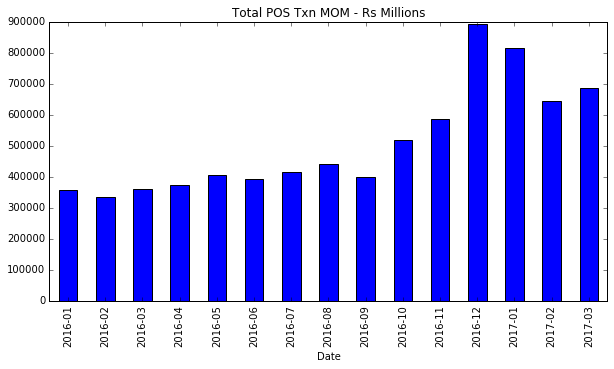

In [17]:
# MoM growth
master_df1.groupby(master_df1.index)['Total POS  Txn AMT'].sum()\
                    .plot(kind='bar',title = "Total POS Txn MOM - Rs Millions",figsize=(10,5))

### Inference

>>- So we can see that there is a spike in POS transactions in Dec'16 which might be due to non availability of cash in market but this has drastically reduced from next month onwards and setelled down to normal limits. Lets see

 
>>- Daily AVG of all the months to see what IT minister has said about POS txns in an article published on 9 Dec

>>- MoM % change

>>- QoQ % change 

### 1. Daily AVG 

To get the Daily Average, First I will show bit complex way to get daily AVG from monthly data. Later I have done samething but in a bit pythonic way. I can't figure out any easier method to dop this. 

We have monthly data - so we can either 

1. Calculate number of days in each and divide by that
2. Upsample from Monthly to Daily with forward fill, Later downsample to Monthly again but this time use a function to calculate AVG 
3. Do same as in 2 but use Lambda to make it simple

#### Option 1

In [18]:
import calendar

dx = master_df1['Total POS  Txn AMT'].groupby(master_df1.index).sum()
days_in_month = [calendar.monthrange(x,y)[1] for x,y in zip(dx.index.year,dx.index.month)]

(dx/days_in_month)[:4]

Date
2016-01    11543.299223
2016-02    11585.998034
2016-03    11663.706180
2016-04    12509.337091
Freq: M, Name: Total POS  Txn AMT, dtype: float64

#### Option 2

In [19]:
master_df2 = master_df1.groupby(master_df1.index)[['Total POS  Txn AMT']].sum().resample('D').ffill()
master_df3 = master_df2.groupby(master_df2.index.asfreq('M')).max()/master_df2.groupby(master_df2.index.asfreq('M')).count()
master_df3.columns = ['Daily AVG Txns']
master_df3.head(2)

,Daily AVG Txns
2016-01,11543.299223
2016-02,11585.998034


#### Option 3

In [20]:
master_df3_temp = master_df1['Total POS  Txn AMT'].groupby(master_df1.index).sum().resample('D').ffill().to_timestamp()\
    .resample('M').apply(lambda x: x.max()/x.count())
    
master_df3_temp[:2]

2016-01-31    11543.299223
2016-02-29    11585.998034
Freq: M, Name: Total POS  Txn AMT, dtype: float64

#### Plot Average Daily POS Transactions

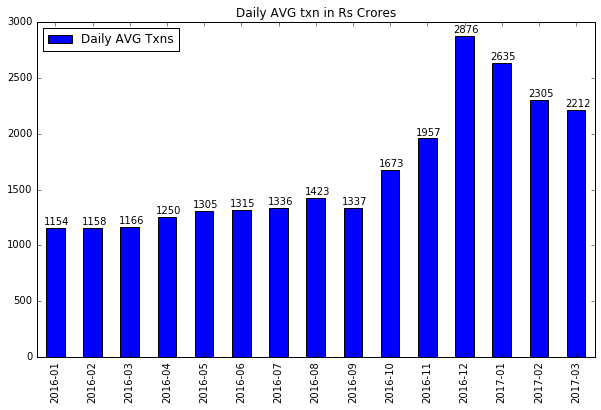

In [21]:
# Convert daily AVG from Millions to Crores
ax = (master_df3*1000000/10000000).plot(kind='bar',title='Daily AVG txn in Rs Crores',figsize=(10,6))

for x,y in enumerate((master_df3*1000000/10000000).values):
    ax.annotate(int(y[0]),(x,y[0]),xytext=(-11,3),textcoords='offset points')

### Inference


>> We can clearly see that AVG daily txn value has increased from approx. 2000 crores to 2900 crores post demonetisation. 
But the worry is the that Daily AVG is again going back to the same tune of post demonetisation which is due to currency coming back in circulation.  

>> <B> Also the Daily AVG looks bit different from what was published in TOI article during Dec'16. Below is the snapshot of TOI artcile </B>

PS: My numbers might be incorrect due to issues with RBI published detais or the porcessing I have done.

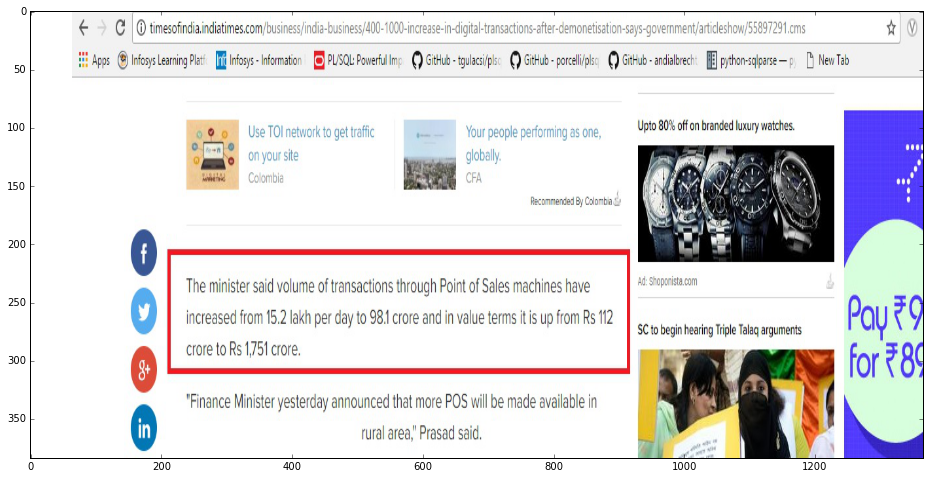

In [22]:
fig = plt.figure(figsize=(16,8))
img = plt.imread('TOI_Article.jpg')
plt.imshow(img[:len(img)/2],aspect='auto')

## 2 & 3. MOM and QoQ % change 

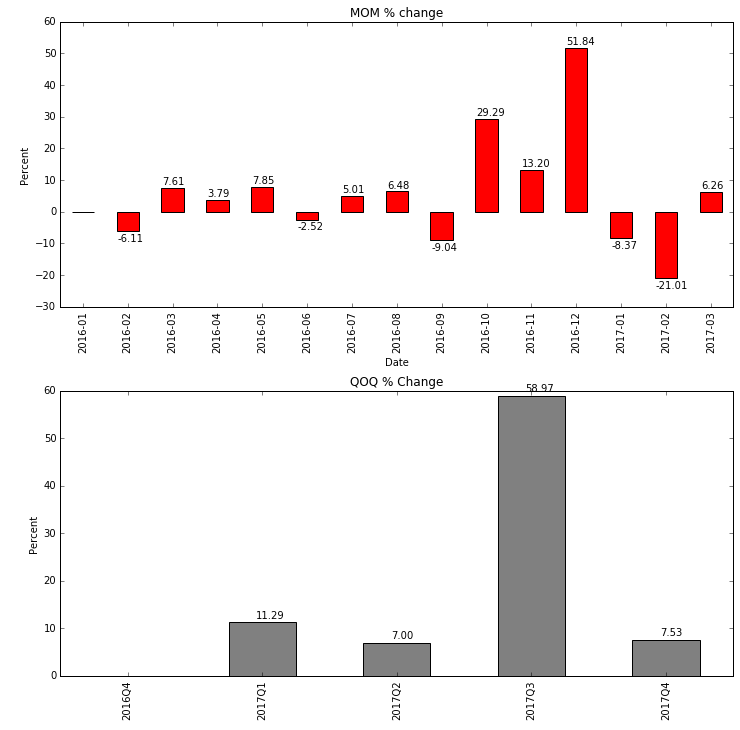

In [23]:
fig = plt.figure()

ax = fig.add_subplot(211)
ax = (master_df1.groupby(master_df1.index)['Total POS  Txn AMT'].sum().pct_change()*100)\
                .plot(kind='bar',color='r',title='MOM % change',figsize=(10,10))

ax.set_ylabel('Percent')    

for x,y in enumerate(master_df1.groupby(master_df1.index)['Total POS  Txn AMT'].sum().pct_change()*100):
    ax.annotate('%.2f'%y,(x,y),xytext=(-10,-10 if y<0 else 3),textcoords='offset points')
    
ax1 = fig.add_subplot(2,1,2)

ax1 = (master_df1['Total POS  Txn AMT'].resample('Q-MAR').sum().pct_change()*100)\
            .plot(kind='bar',color='grey',title='QOQ % Change',figsize=(10,10))
    
for x,y in enumerate(master_df1['Total POS  Txn AMT'].resample('Q-MAR').sum().pct_change()*100):
    ax1.annotate('%.2f'%y,(x,y),xytext=(-6,4),textcoords='offset points')
    
ax1.set_ylabel('Percent')
    
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Inference

>> It is quite evident spike in POS transactions after Demonetisation but this seems to be setteling down with more and more currency comig in circulation. Jan and Feb'17 have been the highest -ve months with respect to POS transaction which is due to December being total out of cash and POS being used highly for FMCG.

## Analysis 2. Is there a decrease in ATM tnx because of demonitisation

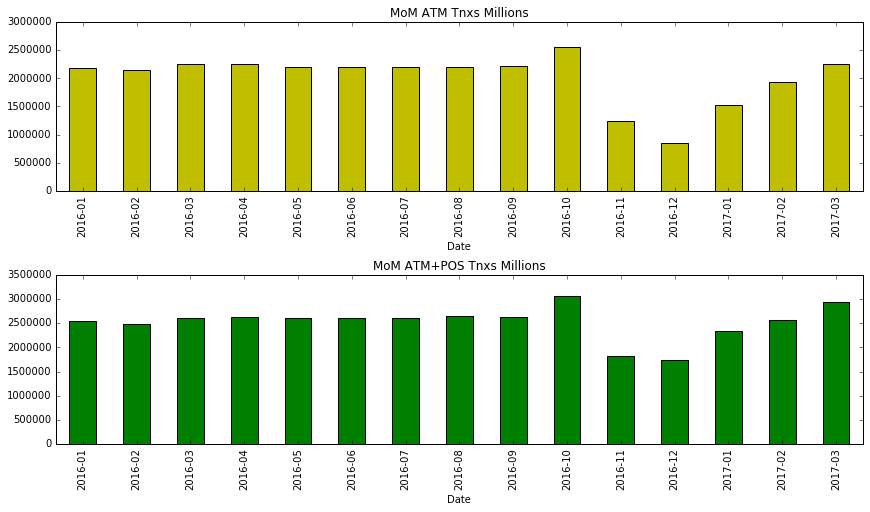

In [24]:
fig = plt.figure()

ax = fig.add_subplot(211)
ax = master_df1[['Credit Cards Amount of transactions (Rs. Millions) ATM',\
                'Debit Cards Amount of transactions (Rs. Millions) ATM']]\
    .sum(1).groupby(master_df1.index).sum().plot(kind='bar',title='MoM ATM Tnxs Millions',figsize=(12,7),facecolor='y')
    
ax1 = fig.add_subplot(212)    
ax1 = master_df1[['Credit Cards Amount of transactions (Rs. Millions) ATM',\
                'Debit Cards Amount of transactions (Rs. Millions) ATM','Total POS  Txn AMT']]\
    .sum(1).groupby(master_df1.index).sum().plot(kind='bar',title='MoM ATM+POS Tnxs Millions',figsize=(12,7),facecolor='g')

fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Ineference

> It is quite evident that ATM transaction were severely hit during demonetisation but more surprising was ATM and POS cumulatively were also hit. I used to think non availability of cash would have been substitured by POS but that doesn't seem to be the case. This was the hit faced by mass who wasn't ready to use POS machines for their daily needs.

#### Another imp point to notice is the significant spike in ATM transactions in October, just before Demonetisation - Is there a reason for it, Can you explain ? 

## Analysis 3: Which Bank has Maximum Card (Cr+Deb) to Number of POS tnx ratio

In [26]:
master_df1['Total Cards Issued'] = master_df1[[u'Credit Cards No .of outstanding cards as at the end of the month'\
                   ,u'Debit Cards No .of outstanding cards as at the end of the month']].sum(1).fillna(method='ffill')

master_df1['POS AMT Per Card'] = master_df1['Total POS  Txn AMT']/master_df1['Total Cards Issued']

master_df5 = master_df1[master_df1['Total Cards Issued']>1000000].groupby('Bank Name')['POS AMT Per Card','Total Cards Issued','Total POS  Txn AMT']\
                .mean().sort_values(by='POS AMT Per Card',ascending=False)[:5].copy()

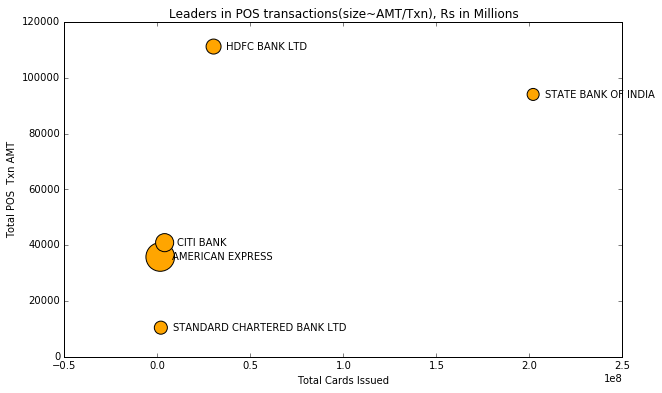

In [27]:
ax = master_df5.plot(kind='scatter',x='Total Cards Issued',y='Total POS  Txn AMT'\
                    ,s=master_df5['POS AMT Per Card'].values*30000,c='orange',figsize=(10,6),\
                        title='Leaders in POS transactions(size~AMT/Txn), Rs in Millions')

for x,y in enumerate(master_df5.values):
    ax.annotate(master_df5.index.values[x],xy=(y[1],y[2]),xytext=(12,-3),textcoords='offset points')

### Inference

>> - As expected SBI is way beyoned everybank in number of Cards Issues which is majority debit
>> - HDFC is again leading in Aggregated Transaction AMT
>> - Amex and Citi are the leaders in per POS transaction amout which is also justified by the fact that these banks are mainly Upper Class Banks in India 

## Analysis 4: Number of Users Per ATM

In [101]:
master_df1['Total ATM'] = master_df1.ix[:,[x.startswith('ATM') for x in master_df1.columns]].sum(1).fillna(1)

In [102]:
master_df1['Cust Per ATM'] = \
master_df1['Debit Cards No .of outstanding cards as at the end of the month'].fillna(0)\
                                                                /master_df1['Total ATM'].fillna(1)

In [103]:
master_df6 = \
master_df1[master_df1['Total Cards Issued']>1000000].groupby('Bank Name')['Cust Per ATM']\
                            .mean().sort_values(ascending=True)

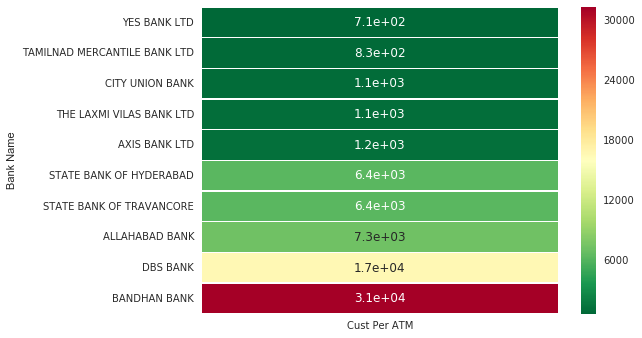

In [126]:
import seaborn as sns
sns.heatmap(pd.DataFrame(pd.concat([master_df6[master_df6 > 0].ix[:5],master_df6[master_df6 > 0].ix[-5:]])), cmap='RdYlGn_r', linewidths=0.5, annot=True)

### Inference

>> - Yes Bank cares most for their custmers. They have more ATM available per customer than AXIS, ICICI and SBI
>> - Bandhan Bank, may be because its growing, has least ATM distribution per customer
>> - Without ATM location we cant say which is best or worst, may be Allahabad bank does ATM geooptimisation, so that they put minumum number of ATM but close to their customer concentrated areas

## Analysis 5: Increase in POS instruments post Demonetisation 

In [245]:
master_df7 = master_df1[(master_df1.index >= pd.Period('2016-11')) & (master_df1['POS On-line']>10000)].copy()
master_df7['Total POS'] = master_df7[[u'POS On-line',u'POS Off-line']].sum(1)

In [248]:
def grp_pct(s):
    s= s.sort_index().pct_change()
    if s.count()>3:
        return s.mean()
    else:
        return 0

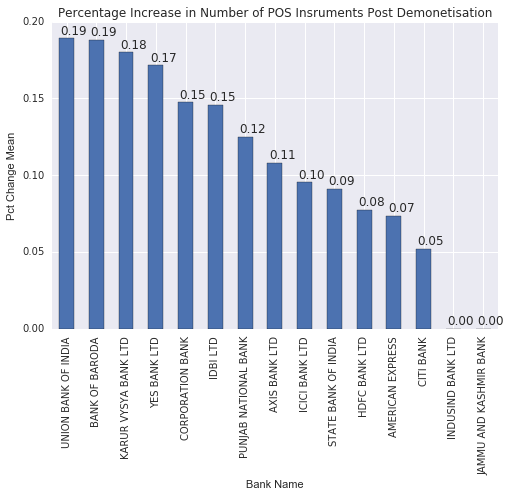

In [249]:
ax = (master_df7.groupby('Bank Name')['Total POS'].apply(grp_pct).sort_values(ascending=False,na_position='last'))[:15]\
    .plot(kind='bar',title='Percentage Increase in Number of POS Insruments Post Demonetisation')
    
ax.set_ylabel('Pct Change Mean')

arrx = master_df7.groupby('Bank Name')['Total POS'].apply(grp_pct).sort_values(ascending=False,na_position='last')[:15].values

for  a,b in enumerate(arrx):
    ax.annotate('%.2f'%b,(a,b),xytext=(-6,4),textcoords='offset points')

### Inference

>>- So the leaders are Union Bank, BOB and KVB in increasing number of POS machines, post demonetisation
>>- This shows that these top banks have increased number of POS to support Digital transactions